In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm   
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import files
uploaded = files.upload()

Saving used_cars_info_.csv to used_cars_info_.csv


In [5]:
#import data 
car=pd.read_csv(r'used_cars_info_.csv') 
#check non-null value
car.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11281 entries, 0 to 11280
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          11281 non-null  object 
 1   Model          11281 non-null  object 
 2   Register_time  11281 non-null  object 
 3   Mile           11281 non-null  object 
 4   Fuel_type      11281 non-null  object 
 5   Used_price     11281 non-null  float64
 6   New_price      11281 non-null  object 
dtypes: float64(1), object(6)
memory usage: 617.1+ KB


In [8]:
#New_price: delete the Null value and change to float data type
car['new_price'] =car.New_price.str.extract(r'(\d+.\d+)') .astype('float64')  
car.dropna(inplace=True)

#Mile: change the values of null or few miles to 0 and change to float type
car['mile'] = car.Mile.str.extract(r'(\d+.\d+)').astype('float64')
car.loc[car.mile.isnull(),'mile']=0.00    
            
#Register_time: delete the Null value    
car = car.loc[car.Register_time != 'Null',:]
car['year']=car.Register_time.str.extract(r'(\d+)').astype('int')
car['month']=car.Register_time.str.extract(r'(\d+m)')
car['month']=car.month.str.extract(r'(\d+)') .astype('int')       
car['time'] = (2018-car.year)*12 + (1-car.month) + 1  

#get the data excluding the Model and Fuel_type


# Visualization and Feature

Text(0.5, 1.0, 'Price for used car ')

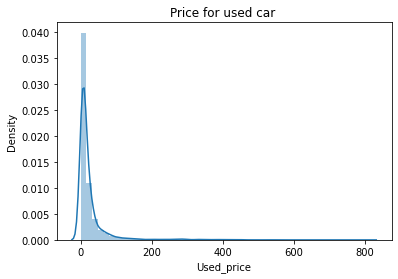

In [9]:
#the price for used cars increase, the Sales decrease
sns.distplot(car.Used_price)
plt.title('Price for used car ')

Text(0.5, 1.0, 'depreciation rate')

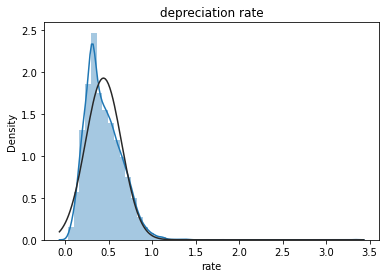

In [10]:
#depreciation rate: used_price/new_price
car['rate']=car.Used_price.div(car.new_price)

#Consider using the depreciation rate as the target variable
sns.distplot(car.rate,fit=norm)
plt.title('depreciation rate')


Text(0.5, 1.0, 'Mile-DepRate')

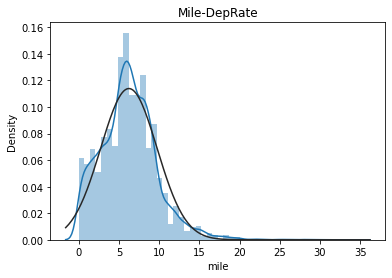

In [11]:
# the mile conforms to the normal distribution, and it is an negative correlation with the depreciation rate 
sns.distplot(car.mile,fit=norm)
plt.title('Mile-DepRate')

Text(0.5, 1.0, 'Mile-DipRate')

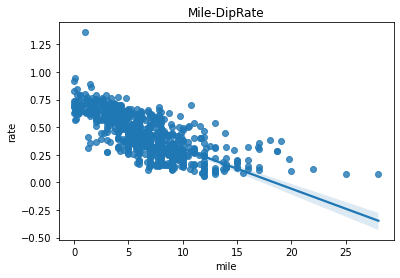

In [15]:
# take BMW as an example
sns.regplot('mile','rate',data=car[car.Brand=='BMW'])
plt.title('Mile-DipRate')

Text(0.5, 1.0, 'Year-Rate')

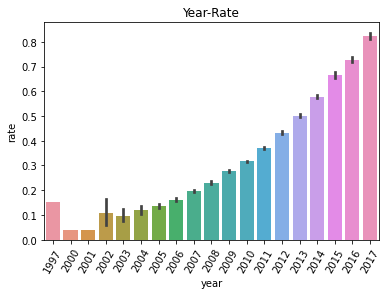

In [13]:
# There is a negative correlation between driving time, registering time and depreciation rate.
sns.barplot('year','rate',data=car)
plt.xticks(rotation=60)
plt.title('Year-Rate')


Text(0.5, 1.0, 'Brand-DisRate(eg. Audi, Benz, BMW)')

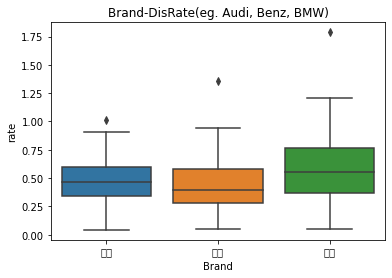

In [16]:
# Brand is related to the depreciation rate
# The average value and depreciation rate are different for each brand, and there are outliers.
sns.boxplot('Brand','rate',data=car[car.Brand.isin(['Audi','Benz','BMW'])])
plt.title('Brand-DisRate(eg. Audi, Benz, BMW)')

Text(0.5, 1.0, 'amount for each brand')

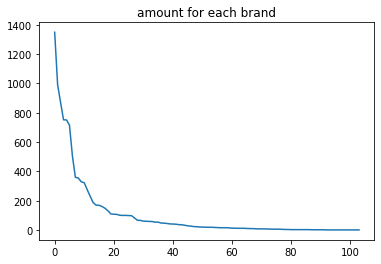

In [17]:
# The number of brands is large and unevenly distributed.
# The number of some brands is too less and excluding these with less than 10 vehicles   
brand_count=car.Brand.value_counts()
brand_count.index=np.arange(len(brand_count.values))
brand_count.plot()
plt.title('amount for each brand')

# Modeling

In [24]:
# Remove outliers value, and filtering the features
car1=car[(car.rate<1)&(car.mile<25)]
car1=car1[~car1.Model.isin(['1995','1999','2000','2001','2002'])]
number=dict(zip(car1.groupby('Brand').rate.count().index,car1.groupby('Brand').rate.count().values))
car1['number']=car1.Brand.map(number)
car1=car1.loc[car1.number>=10] 
x=car1[['Brand','mile','time','Model']]
y=car1['rate'] 
# feature filting and encoding the variable
x=pd.get_dummies(x)

In [22]:
# Diving training set and testing set
xtrain,xtest,ytrain,ytest=train_test_split(x.values,y.values,test_size=.3,random_state=0)
xstd=StandardScaler().fit_transform(x) 
xtrainstd,xteststd,ytrain,ytest=train_test_split(xstd,y.values,test_size=.3,random_state=0)

In [25]:
# linear regression model
lr=LinearRegression()
lr.fit(xtrain,ytrain)
lrpred=lr.predict(xtest)
lrpredtrain=lr.predict(xtrain)
# testing set result
print(r_score (ytest,lrpred))
# training set result
print(r_score (ytrain,lrpredtrain))

0.8669428574244431
0.8594804025897764


In [28]:
# random forest model with default parameters 
rfr = RandomForestRegressor()
rfr.fit(xtrain,ytrain)
rpred=rfr.predict(xtest)
rpredtrain=rfr.predict(xtrain)
# testing set result
print(r_score (ytest,rpred)) 
# training set result
print(r_score (ytest,rpredtrain))

0.8753017649870939
0.8622494426824513


In [29]:
# Xgboost model with default parameters
xgb=XGBRegressor()
xgb.fit(xtrain,ytrain)
xgbpred=xgb.predict(xtest)
xgbpredtrain=xgb.predict(xtrain)
# testing set result
print(r_score (ytrain,xgbpredtrain))
# training set result
print(r_score (ytest,xgbpred))

[18:57:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8807846709266941
0.8798086358957151
